In [1]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN,load_model_info
from density_utils import draw_density_ratio, refine_sample_GPC, refine_sample2, draw_density_ratio2, draw_density_ratio_GPC, refine_sample_GP, refine_sample2_GP

from utils import load_item, show_grasp, count_real_positives
from dataset import ToyGraspDataset

%load_ext autoreload
%autoreload 2

# GP Classifier Sim+ vs Real+

In [2]:
import torch
import matplotlib.pyplot as plt
from torch import distributions
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib as mpl
mpl.rcParams['font.size'] = 14

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from network import ClassifierNN, train_network, save_model_info, load_model_info

from density_utils import draw_density_ratio, refine_sample, refine_sample2, draw_density_ratio2, refine_sample_GP, draw_density_ratio_GP

from utils import load_item, show_grasp
from dataset import ToyGraspDataset

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

torch.manual_seed(42)


sim2real!!!


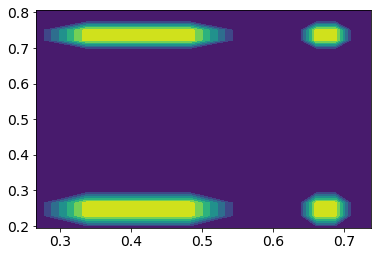

In [3]:
# USING 2D FORK DATA ===============================
n = 10

# train classifier
train_dataset = ToyGraspDataset(root='data', name='sim2real_train', size=5000, is_pos_label=True, device=device)
train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True)

test_dataset = ToyGraspDataset(root='data', name='sim2real_test', size=n, is_pos_label=True, device=device)
test_dataloader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# dataset = ToyGraspDataset(root='data', size=50)
train_x = torch.Tensor(train_dataset.data[:,:2])
train_y = torch.Tensor(train_dataset.data[:,2]).long()

train_x[:,0] /= 244
train_x[:,1] /= 2*(3.14)

# y = train_dataset.data[:,2].reshape(-1,1)

test_x = torch.Tensor(test_dataset.data[:,:2])
test_x_mat = torch.reshape(test_x[:,0], (n, n))
test_y_mat = torch.reshape(test_x[:,1], (n, n))

test_x[:,0] /= 244
test_x[:,1] /= 2*(3.14)

test_y = torch.Tensor(test_dataset.data[:,2]).long()
test_labels = torch.reshape(test_y, (n, n))


plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

In [4]:
print(train_y.sum())
print(train_y.shape[0])

tensor(1070)
5000


In [24]:
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel



# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x,
                         likelihood.transformed_targets,
                         likelihood,
                         num_classes=likelihood.num_classes)

In [25]:
import math
import torch
import numpy as np
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50




# Find optimal model hyperparameters

model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


# train_x = train_x.to(device)
# model = model.to(device)
# likelihood = likelihood.to(device)
# likelihood.transformed_targets = likelihood.transformed_targets.to(device)


for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = likelihood(model(train_x))
    # Calc loss and backprop gradients
    loss = -mll(output, likelihood.transformed_targets).sum()
#     loss = -mll(output, train_y).sum()
    loss.backward()
    if i % 5 == 0:
#         print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.mean().item()
#             model.likelihood.second_noise_covar.noise.mean().item()
        ))
    optimizer.step()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/50 - Loss: 4.739   lengthscale: 0.693
Iter 6/50 - Loss: 4.621   lengthscale: 0.474
Iter 11/50 - Loss: 4.516   lengthscale: 0.311
Iter 16/50 - Loss: 4.396   lengthscale: 0.198
Iter 21/50 - Loss: 4.228   lengthscale: 0.121
Iter 26/50 - Loss: 4.044   lengthscale: 0.069
Iter 31/50 - Loss: 3.846   lengthscale: 0.038
Iter 36/50 - Loss: 3.751   lengthscale: 0.022
Iter 41/50 - Loss: 3.730   lengthscale: 0.016
Iter 46/50 - Loss: 3.698   lengthscale: 0.014


In [36]:
model.eval()
likelihood.eval()
# t_x = test_x.clone().to(device)
with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = likelihood(model(test_x))
#     test_dist = _test_dist.clone().cpu()
    _pred_means = test_dist.mean
    pred_means = _pred_means.clone().cpu()

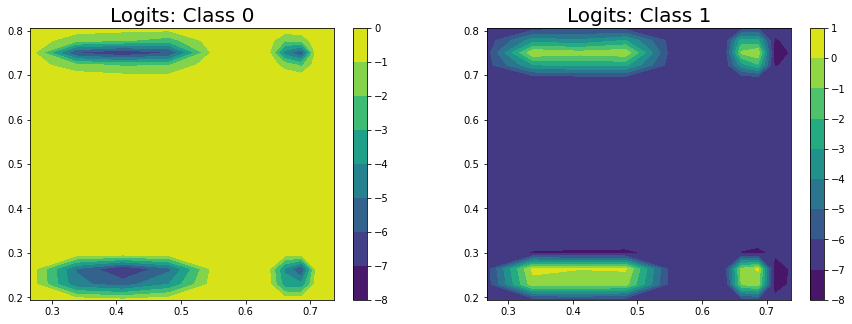

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((n,n))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)

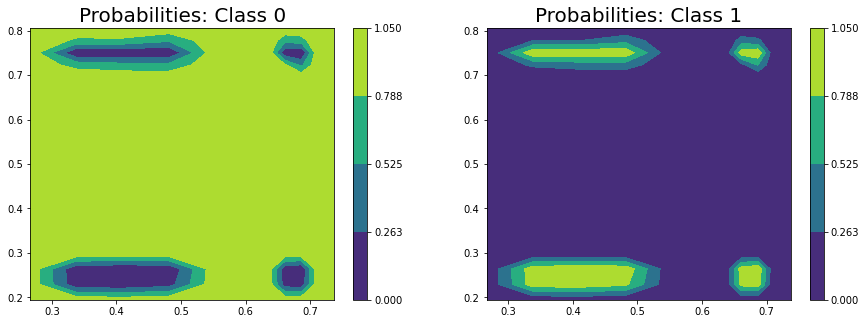

In [38]:
_pred_samples = test_dist.sample(torch.Size((256,))).exp()
pred_samples = _pred_samples.cpu()
probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

fig, ax = plt.subplots(1, 2, figsize = (15, 5))

levels = np.linspace(0, 1.05, 5)
for i in range(2):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((n,n)), levels=levels
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

Text(0.5, 1.0, 'Estimated Response')

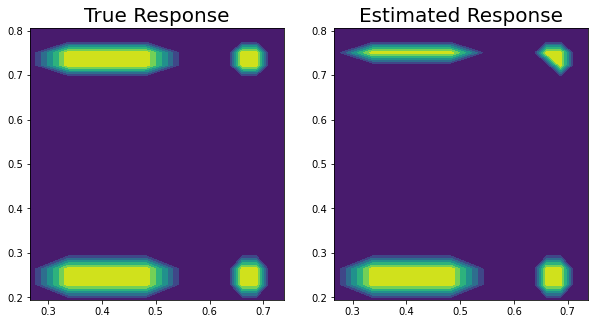

In [39]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)

ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), pred_means.max(0)[1].reshape((n,n)))
ax[1].set_title('Estimated Response', fontsize=20)

Text(0.5, 1.0, 'Estimated Response')

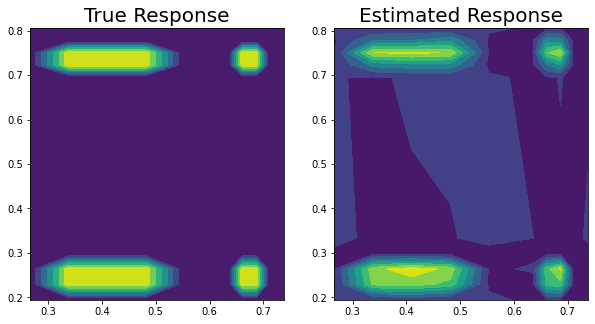

In [40]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())
ax[0].set_title('True Response', fontsize=20)


logit = pred_means[1,:] - pred_means[0,:]
ax[1].contourf(test_x_mat.numpy(), test_y_mat.numpy(), logit.reshape((n,n)))
ax[1].set_title('Estimated Response', fontsize=20)

In [31]:
d_score = pred_means[1,:] - pred_means[0,:]
print(d_score)

tensor([-5.9273, -6.2121, -5.5764, -6.3408, -5.6856, -6.2964, -6.1613, -6.0072,
        -6.3168, -6.1165, -6.2682,  4.3924,  4.9539,  3.3359, -6.2717, -6.4608,
         2.6397,  3.3314, -7.2556, -6.5027, -6.1275,  5.3168,  7.1513,  5.3855,
        -6.2039, -5.8622,  3.4504,  6.3197, -7.5352, -6.5808, -6.1550, -6.7770,
        -6.8189, -6.8721, -6.3731, -6.2628, -6.6502, -6.8846, -6.5262, -6.2969,
        -5.7992, -6.1522, -6.2199, -6.0775, -5.6867, -5.9947, -6.2466, -6.3037,
        -6.2907, -5.8499, -5.9117, -6.1690, -5.8220, -5.7165, -5.8135, -6.2119,
        -6.2152, -5.9348, -6.3299, -6.2041, -6.0419, -1.3450, -0.6297, -0.7397,
        -6.3234, -6.2984, -2.1267,  0.0590, -6.8096, -6.3380, -6.1450,  5.9697,
         6.5019,  5.7922, -6.1668, -6.0038,  3.7087,  5.9179, -7.4085, -6.5300,
        -6.2225, -1.9176, -1.9896, -0.5104, -6.1897, -6.1402, -0.6965, -1.1108,
        -6.8313, -6.3909, -5.9224, -6.0482, -5.6533, -5.9399, -5.8662, -6.0836,
        -6.3574, -5.9870, -6.5689, -6.15

In [32]:
# my_sample = torch.FloatTensor([[60, 1.5],
#                                [80, 1.5]]).to(device)

# my_sample[:,0] /= 224
# my_sample[:,1] /= (2*3.14)


# model.to(device)
# model.eval()
# pred = model(my_sample).mean
# print(pred)
# # print(min(pred).item(), max(pred).item())
next(model.parameters()).is_cuda

False

In [33]:
steps_refinement = 100


# from the GP classifier
# f2
# Nq = info2['pos_samples_size'], Np = info2['neg_samples_size']

Nq = int(train_y.sum())
Np = int(train_y.size()[0] - train_y.sum())

# print(my_sample)
# my_sample = torch.FloatTensor([[25, 0.3],
my_sample = torch.FloatTensor([[60, 1.5],
                               [80, 1.5]])#[160, 3]
# my_sample = torch.FloatTensor([[210, 3]])

my_sample[:,0] /= 224
my_sample[:,1] /= (2*3.14)

# my_sample = my_sample.repeat(1,200)

# model.to(device)
model.eval()
# likelihood.to(device)
likelihood.eval()

all_x1, all_v1 = refine_sample_GPC(my_sample, model, likelihood, steps=steps_refinement,
# all_x1, all_v1 = refine_sample_GP(my_sample.to(device), model, steps=steps_refinement,
#                                eta=0.0001, noise_factor=0.0000,
                               eta=0.1, noise_factor=0.000,
#                                eta=0.5, noise_factor=0.000,
                              Nq = Nq, Np = Np)

1070 3930


  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
# all_x1
# device

  0%|          | 0/28685 [00:00<?, ?it/s]

-2.2225502 2.2081423


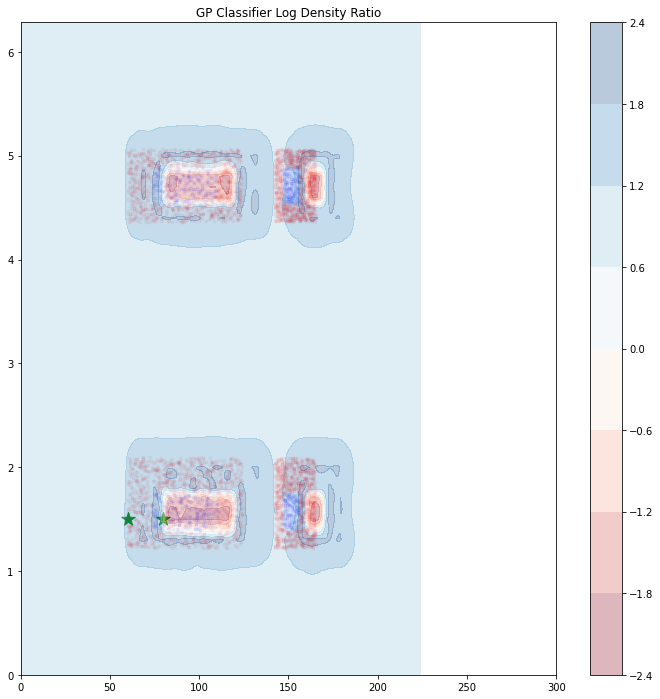

In [35]:
import torch
torch.cuda.empty_cache()

pos_masks = train_y == 1
neg_masks = ~pos_masks
fig, ax = plt.subplots(nrows=1, figsize=(12,12))
ax.scatter(train_x[pos_masks][:,0]*224, train_x[pos_masks][:,1]*(2*3.14), marker='.', alpha=0.05, color='b')
ax.scatter(train_x[neg_masks][:,0]*224, train_x[neg_masks][:,1]*(2*3.14), marker='.', alpha=0.05, color='r')

plt.scatter(my_sample[:, 0]*224, my_sample[:,1]*(2*3.14), marker='*', color='g', s=200)
# plt.scatter(my_sample[:, 0], my_sample[:,1], marker='*', color='g', s=200)

for i in range(1, steps_refinement, 1):
    plt.scatter(all_x1[i][:, 0]*224, all_x1[i][:,1]*(2*3.14), marker='d', color='g', s=4)
#     plt.scatter(all_x1[i][:, 0], all_x1[i][:,1], marker='d', color='g', s=4)

Z, CS = draw_density_ratio_GPC(ax=ax,
                   model=model,
                   likelihood=likelihood,
#                    model=model.to(device),
#                    likelihood=likelihood.to(device),
#                    p_type='p_y_given_x',
                   p_type='log_density_ratio',
                   device=device,
                   x_lim=[0, 224],
                   y_lim=[0, 2*np.pi],
                   cmap='RdBu',
                   step_size=0.1,
                   Np=Np, Nq=Nq)
fig.colorbar(CS, ax=ax)



ax.set_title(f'GP Classifier Log Density Ratio')
ax.set_xlim([0, 300])
ax.set_ylim([0, 2*np.pi])

plt.show()